## Driving Range Prediction and Energy Consumption in EV

Analysis is done on a particular Electrical Vehicle model car-Volkswagen eGolf.

Understanding as a machine learning problem: 

1- Driving range prediction is a regression problem.

2- Models need not be time-constrained.

3- Some form of Interpretability of the predicted driving range is needed.

4- MAE and R-squared were used for measuring the performance of the model.

### Data

a public dataset (https://www.spritmonitor.de/en/detail/1131375.html?page=3)

#### Libraries from Pyton

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
input_path = 'input_dataset/volkswagen_e_golf.csv'
df = pd.read_csv(input_path)

#### Sample of data

In [3]:
df.head()

,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
0,Volkswagen,Golf,e-Golf,85,08.02.2019,80,NaN,Electricity,Winter tires,0,0,1,Normal,17.8,0,1,53.0,1.0
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50,12.29,Electricity,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43,8.68,Electricity,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44,1.50,Electricity,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76,14.44,Electricity,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   manufacturer            3345 non-null   object 
 1   model                   3345 non-null   object 
 2   version                 3345 non-null   object 
 3   power(kW)               3345 non-null   int64  
 4   fuel_date               3345 non-null   object 
 5   trip_distance(km)       3344 non-null   object 
 6   quantity(kWh)           3344 non-null   float64
 7   fuel_type               3345 non-null   object 
 8   tire_type               3345 non-null   object 
 9   city                    3345 non-null   int64  
 10  motor_way               3345 non-null   int64  
 11  country_roads           3345 non-null   int64  
 12  driving_style           3345 non-null   object 
 13  consumption(kWh/100km)  3345 non-null   float64
 14  A/C                     3345 non-null   

#### Data Overview

“ecr_deviation,” : difference between the energy consumption rate recorded at each trip and the value announced by the manufacturer, which is stated as 16.8 kilowatts per hundred kilometers.

“a/c” : inside vehicle air-conditioning

“park_heating” is the car’s heating system
the useless columns, such as model and theversion of the vehicle, are eliminated and the “distance (km)” column is labeled as the target.

In [5]:
df['city'].value_counts()

1    2323
0    1022
Name: city, dtype: int64

In [6]:
df['motor_way'].value_counts()

1    2225
0    1120
Name: motor_way, dtype: int64

In [7]:
df['country_roads'].value_counts()

1    1963
0    1382
Name: country_roads, dtype: int64

In [8]:
df['A/C'].value_counts()

0    3195
1     150
Name: A/C, dtype: int64

In [9]:
df['park_heating'].value_counts()

0    2714
1     631
Name: park_heating, dtype: int64

trip_distance(km) is a numeric data type

city, motor_way, country_roads, A/C, park_heating are binomial data types can be converted to string types or can be remained as_it_is.

In [10]:
def converttype(value, default, t):
    if t == 'numeric':
        try:
            return float(value)
        except (ValueError,TypeError):
            return(default)
    if t == 'str':
        try:
            return str(value)
        except (ValueError, TypeError):
            return(defualt)
            
            

In [11]:
df['trip_distance(km)'] = df['trip_distance(km)'].map(lambda x : converttype(x, np.nan, 'numeric'))

In [12]:
df.dtypes

manufacturer               object
model                      object
version                    object
power(kW)                   int64
fuel_date                  object
trip_distance(km)         float64
quantity(kWh)             float64
fuel_type                  object
tire_type                  object
city                        int64
motor_way                   int64
country_roads               int64
driving_style              object
consumption(kWh/100km)    float64
A/C                         int64
park_heating                int64
avg_speed(km/h)           float64
ecr_deviation             float64
dtype: object

In [13]:
# Observing nonstandard data in Object variables

print("power")
display(df['power(kW)'].value_counts())

# manufacturer
print("Manufacturers")
display(df['manufacturer'].value_counts())

# models
print("Models")
display(df['model'].value_counts())

# versions
print("Versions")
display(df['version'].value_counts())

# fuel type
print("Fuel type")
display(df['fuel_type'].value_counts())

# type type
print("tire type")
display(df['tire_type'].value_counts())

# driving_style
print("driving_style")
display(df['driving_style'].value_counts())

power


85    3345
Name: power(kW), dtype: int64

Manufacturers


Volkswagen    3345
Name: manufacturer, dtype: int64

Models


Golf    3345
Name: model, dtype: int64

Versions


e-Golf    3345
Name: version, dtype: int64

Fuel type


Electricity    3345
Name: fuel_type, dtype: int64

tire type


Summer tires    1826
Winter tires    1519
Name: tire_type, dtype: int64

driving_style


Moderate    2334
Normal       912
Fast          99
Name: driving_style, dtype: int64

##### No Non-standard missing values found in object datatypes

In [14]:
# standard missing values
df.isnull().sum()[df.isnull().sum() > 0]

trip_distance(km)     4
quantity(kWh)         1
avg_speed(km/h)      13
dtype: int64

drop one record for quantity

In [15]:
# We cannot impute quantity (kWh) and there are only one missing value. We will drop that row.
df.drop(axis = 0, index = 0, inplace=True)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


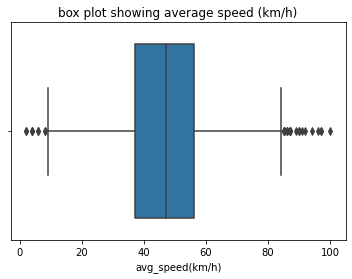

In [16]:
plt.title('box plot showing average speed (km/h)')
sns.boxplot(df['avg_speed(km/h)'])
plt.show()

In [17]:
df['avg_speed(km/h)'].describe()

count    3331.000000
mean       46.745392
std        16.273316
min         2.000000
25%        37.000000
50%        47.000000
75%        56.000000
max       100.000000
Name: avg_speed(km/h), dtype: float64

In [18]:
df['avg_speed(km/h)'].mode()

0    49.0
dtype: float64

In [19]:
null_ave_speed_df = df[df['avg_speed(km/h)'].isnull()]

In [20]:
null_ave_speed_df.index

Int64Index([739, 795, 819, 895, 897, 923, 924, 938, 939, 2337, 2594, 2795,
            3228],
           dtype='int64')

In [21]:
for index, row in df.iterrows() :
    if index not in null_ave_speed_df.index : 
        a = 10
    else :
        mean = df[
            (df['city'] == row['city']) &
            (df['motor_way'] == row['motor_way']) &
            (df['country_roads'] == row['country_roads']) &
            (df['driving_style'] == row['driving_style'])
        ]['avg_speed(km/h)'].mean()
        median = df[
            (df['city'] == row['city']) &
            (df['motor_way'] == row['motor_way']) &
            (df['country_roads'] == row['country_roads']) &
            (df['driving_style'] == row['driving_style'])
        ]['avg_speed(km/h)'].median()

     
        if(abs(mean - median) > 5) :
            df.loc[index, 'avg_speed(km/h)'] = median
        else :
            df.loc[index, 'avg_speed(km/h)'] = mean

In [22]:
# Check the missing values again.
df.isnull().sum()[df.isnull().sum() > 0]

trip_distance(km)    4
dtype: int64

In [23]:
target_null_rows_df = df[df['trip_distance(km)'].isnull()]

df.drop(axis = 0, index = target_null_rows_df.index, inplace=True)

In [24]:
# Check the missing values again.
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

### Prepare Stage0 Dataset for by removing unwanted features

In [25]:
unwanted_features = ['manufacturer','model','version','power(kW)', 'fuel_type','fuel_date']
df.drop(axis= 1, columns= unwanted_features,inplace=True)

In [26]:
df.head()

,trip_distance(km),quantity(kWh),tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
1,50.0,12.29,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,43.0,8.68,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,44.0,1.50,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,76.0,14.44,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2
5,15.0,6.84,Winter tires,1,0,0,Normal,16.1,0,1,23.0,-0.7


In [87]:
df.to_csv('processed_stage0.csv')

In [28]:
# drop the tripdistance column in this df
target_null_rows_df.drop(columns = ['trip_distance(km)','manufacturer', 'model', 'version', 'power(kW)', 'fuel_type', 'fuel_date'], inplace=True)
target_null_rows_df.to_csv('test_additional_raw_stage0_data.csv', index = False)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Analysis data

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

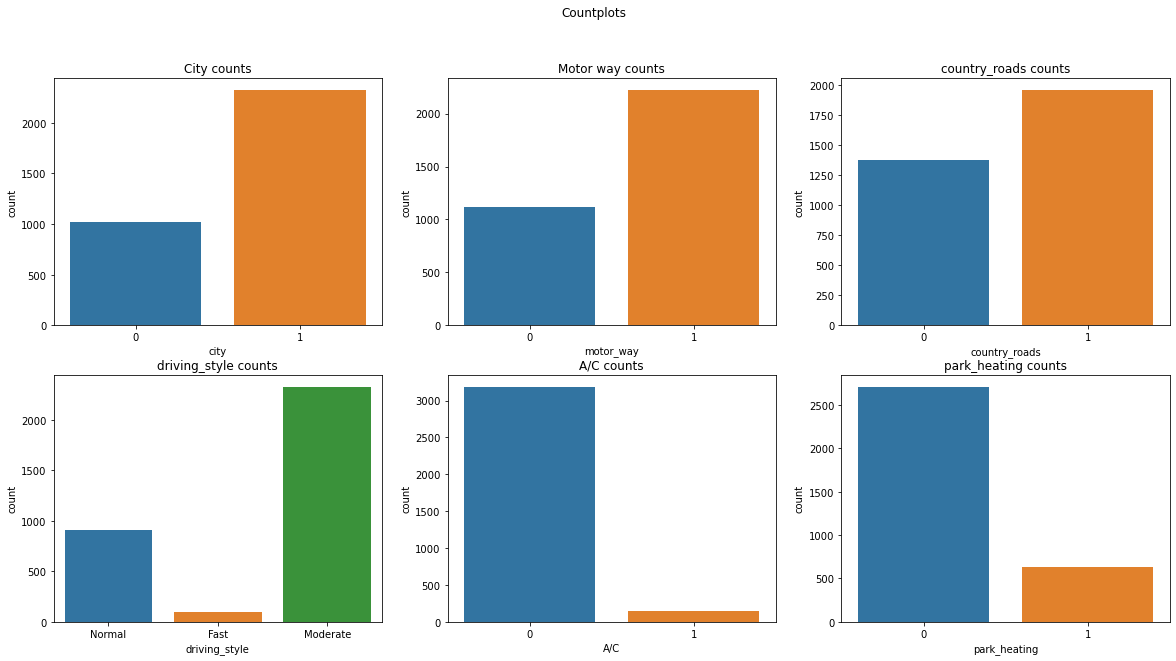

In [33]:
# city
plt.figure(figsize=(20, 10))
plt.suptitle("Countplots")
plt.subplot(2, 3, 1)
plt.title("City counts")
sns.countplot(df['city'])

plt.subplot(2, 3, 2)
plt.title("Motor way counts")
sns.countplot(df['motor_way'])

plt.subplot(2, 3, 3)
plt.title("country_roads counts")
sns.countplot(df['country_roads'])

plt.subplot(2, 3, 4)
plt.title("driving_style counts")
sns.countplot(df['driving_style'])

plt.subplot(2, 3, 5)
plt.title("A/C counts")
sns.countplot(df['A/C'])

plt.subplot(2, 3, 6)
plt.title("park_heating counts")
sns.countplot(df['park_heating'])

plt.show()

#### Observations

1- EV's trials are mostly in City and one way, moderately drived.

2- EV's trials with a/c is on is very less. so the data is biased towards non-ac trials and with no park heating.

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


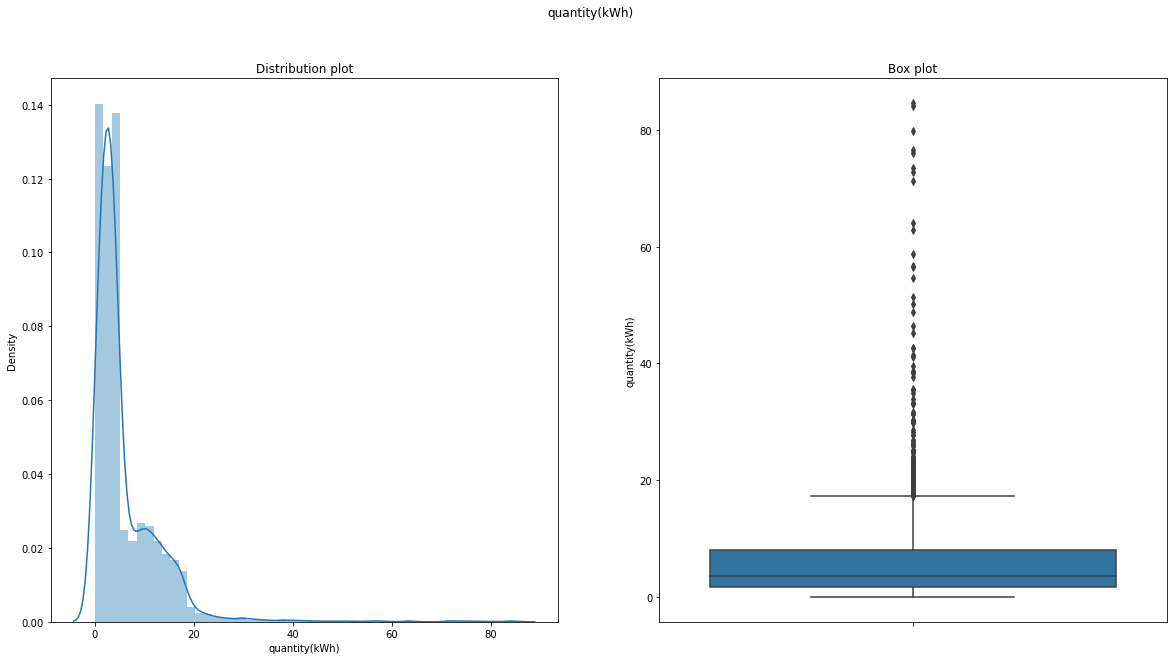

In [38]:
# quantity(kWh)
plt.figure(figsize=(20, 10))
plt.suptitle("quantity(kWh)")
plt.subplot(1, 2, 1)
plt.title("Distribution plot")
sns.distplot(df['quantity(kWh)'], kde = True)

plt.subplot(1, 2, 2)
plt.title("Box plot")
sns.boxplot(y=df['quantity(kWh)'])

plt.show()

#### Observations

The distribution is right skewed. We can see the outliers in range >= 40

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


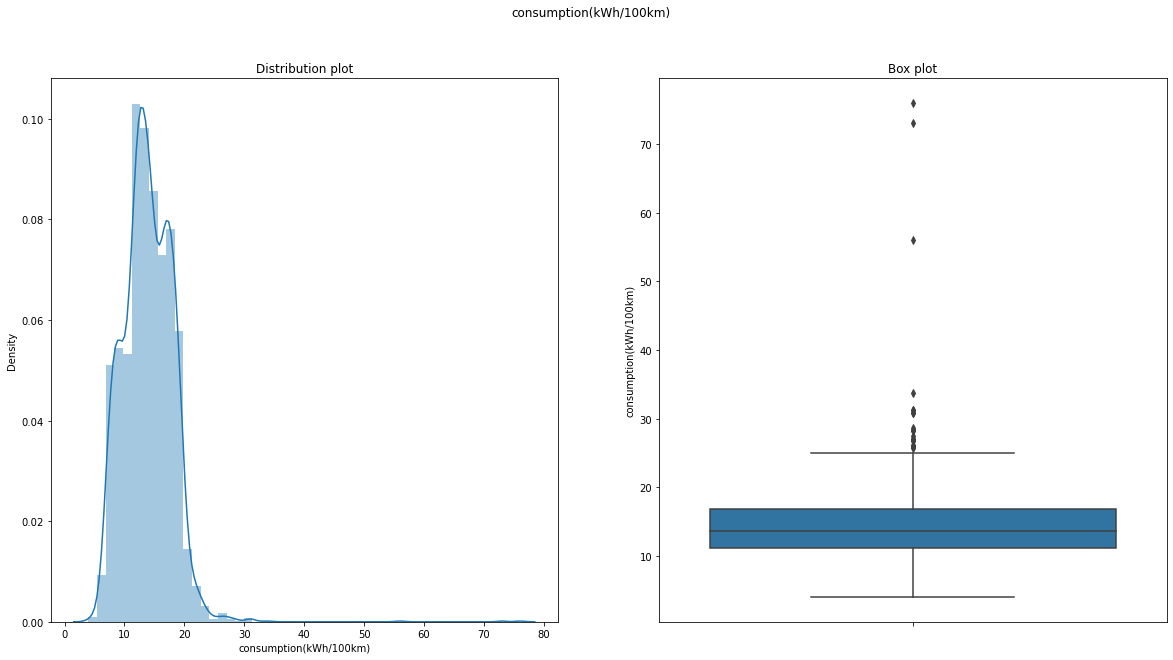

In [40]:
# consumption(kWh/100km)

plt.figure(figsize=(20, 10))
plt.suptitle("consumption(kWh/100km)")
plt.subplot(1, 2, 1)
plt.title("Distribution plot")
sns.distplot(df['consumption(kWh/100km)'], kde = True)

plt.subplot(1, 2, 2)
plt.title("Box plot")
sns.boxplot(y=df['consumption(kWh/100km)'])

plt.show()

#### Observations

The distribution is near normal with right skewed.
There are very few outliers above 50 kwh/100km

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


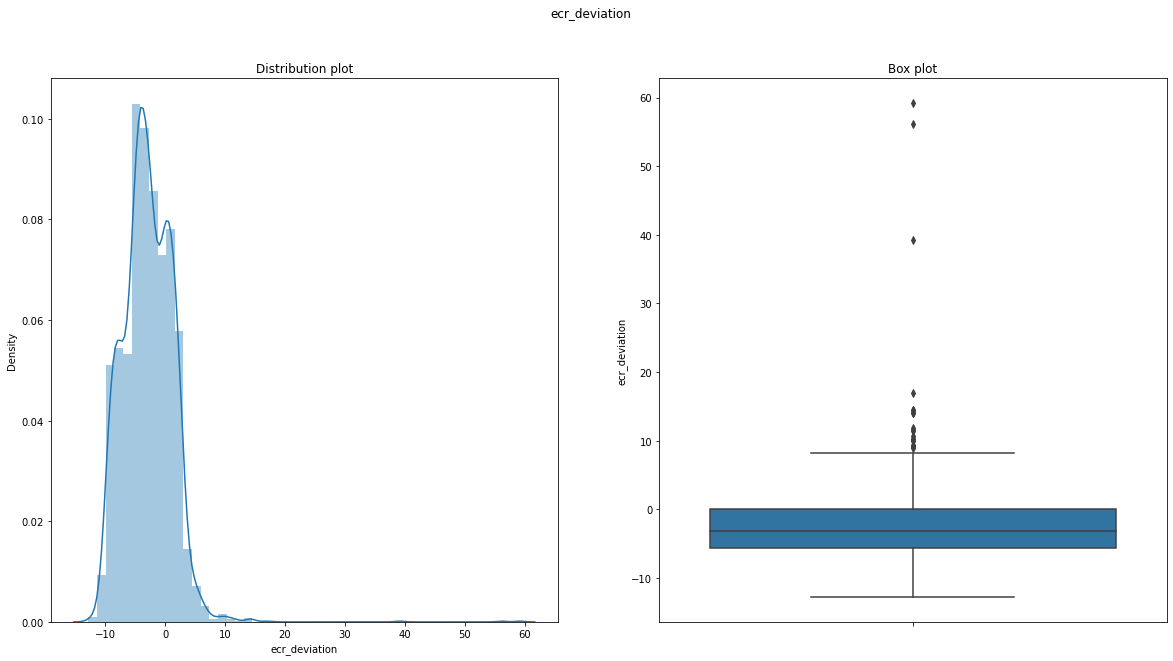

In [41]:
# ecr_deviation

plt.figure(figsize=(20, 10))
plt.suptitle("ecr_deviation")
plt.subplot(1, 2, 1)
plt.title("Distribution plot")
sns.distplot(df['ecr_deviation'], kde = True)

plt.subplot(1, 2, 2)
plt.title("Box plot")
sns.boxplot(y=df['ecr_deviation'])

plt.show()

In [42]:
df['ecr_deviation'].describe()

count    3340.000000
mean       -2.879608
std         4.183439
min       -12.800000
25%        -5.600000
50%        -3.100000
75%         0.000000
max        59.200000
Name: ecr_deviation, dtype: float64

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


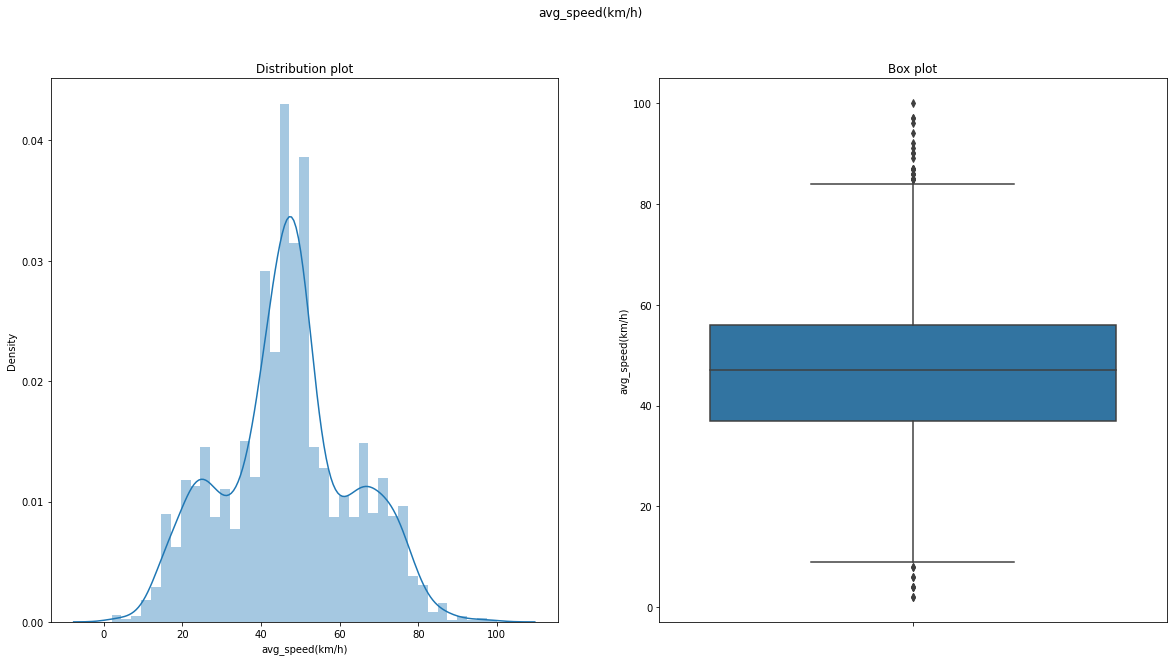

In [43]:
# ave_speed

plt.figure(figsize=(20, 10))
plt.suptitle("avg_speed(km/h)")
plt.subplot(1, 2, 1)
plt.title("Distribution plot")
sns.distplot(df['avg_speed(km/h)'], kde = True)

plt.subplot(1, 2, 2)
plt.title("Box plot")
sns.boxplot(y=df['avg_speed(km/h)'])

plt.show()

#### Observations

The distribution is near normal. with left and right skewness but very small. We see the outliers bewlow 10 and above 80 km/h

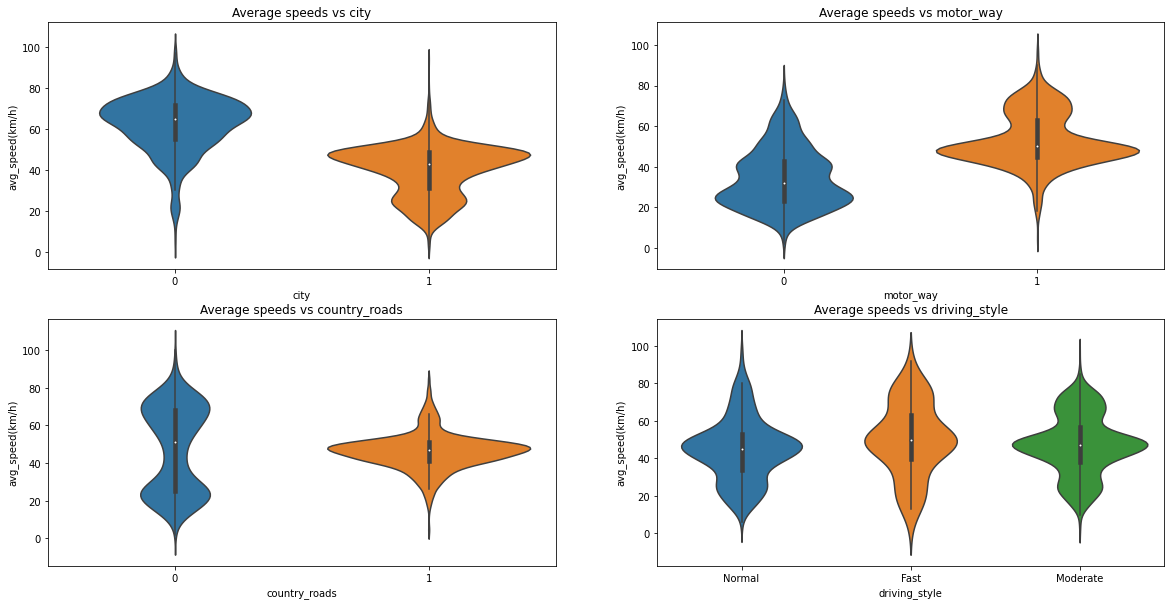

In [44]:
#plt.title("Average speeds distribution among city, motor_way, driving style, country_roads")
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.title("Average speeds vs city")
sns.violinplot(x = 'city', y = 'avg_speed(km/h)', data = df)

plt.subplot(2, 2, 2)
plt.title("Average speeds vs motor_way")
sns.violinplot(x = 'motor_way', y = 'avg_speed(km/h)', data = df)

plt.subplot(2, 2, 3)
plt.title("Average speeds vs country_roads")
sns.violinplot(x = 'country_roads', y = 'avg_speed(km/h)', data = df)

plt.subplot(2, 2, 4)
plt.title("Average speeds vs driving_style")
sns.violinplot(x = 'driving_style', y = 'avg_speed(km/h)', data = df)

plt.show()

#### Observation

InterQuartile Range of Avg_speed is clearly separated among city's. City '0' have higher avg speeds.

InterQuartile Range of Avg_speed is clearly separated among motor_way's. Motor_way '1' have higher avg speeds.

avg speed range is widespread in countryroad '0' compare to '1'.

### role of avg_speed in driving_range

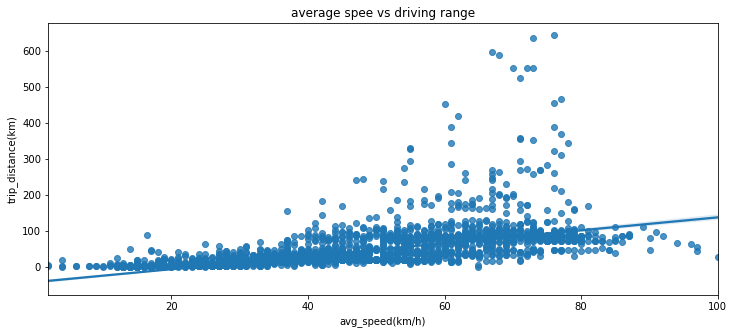

In [46]:
plt.figure(figsize=(12, 5))
plt.title("average spee vs driving range")
sns.regplot(x = 'avg_speed(km/h)', y = 'trip_distance(km)', data = df)
plt.show()

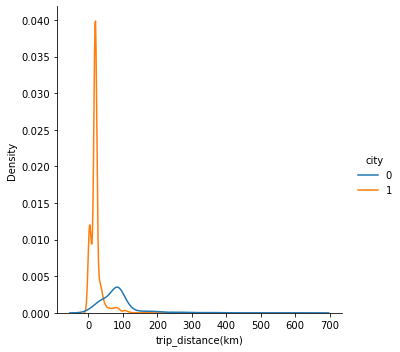

In [47]:
sns.displot(data= df , x = 'trip_distance(km)', kind= 'kde',hue= 'city')

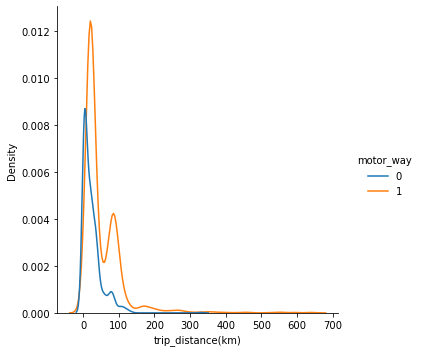

In [48]:
sns.displot(data= df , x = 'trip_distance(km)', kind= 'kde',hue= 'motor_way')

#### Observations

We can see data points having an upward trend till 80 km/hr, so the avg_speed will be a feature to consider for distance range.
tripdistance is lower in city's
one way have larger distance distance ranges with more frequencies in (50 - 300 km). one way has more than 350km range.

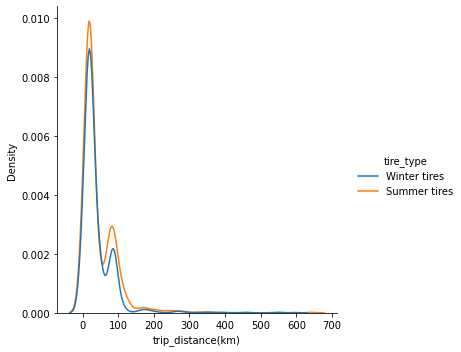

In [52]:
sns.displot(data = df, x= 'trip_distance(km)', kind = 'kde', hue = 'tire_type')

#### Observation

trip distance distribution is same for all tire types. may be this is not a useful feature for predicting distance_range.

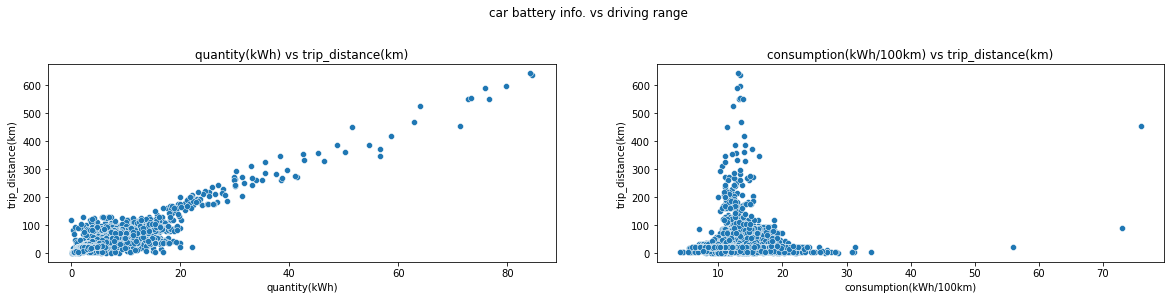

In [53]:
# Quantity on trip distance
plt.figure(figsize=(20, 8))
plt.suptitle("car battery info. vs driving range")
plt.subplot(2, 2, 1)
plt.title("quantity(kWh) vs trip_distance(km)")
sns.scatterplot(x = 'quantity(kWh)', y = 'trip_distance(km)', data = df)

plt.subplot(2, 2, 2)
plt.title("consumption(kWh/100km) vs trip_distance(km)")
sns.scatterplot(x = 'consumption(kWh/100km)', y = 'trip_distance(km)', data = df)
plt.show()

#### Observation

quantity above 20kwh is directly proportional to trip distance.
quantity in range 0 to 20, maynot alone determine the trip distance, we need to combine some more features to determine the tripdistance for quantity kwh
trip distance is higher in EV's having energy consumption range in 10 to 20.

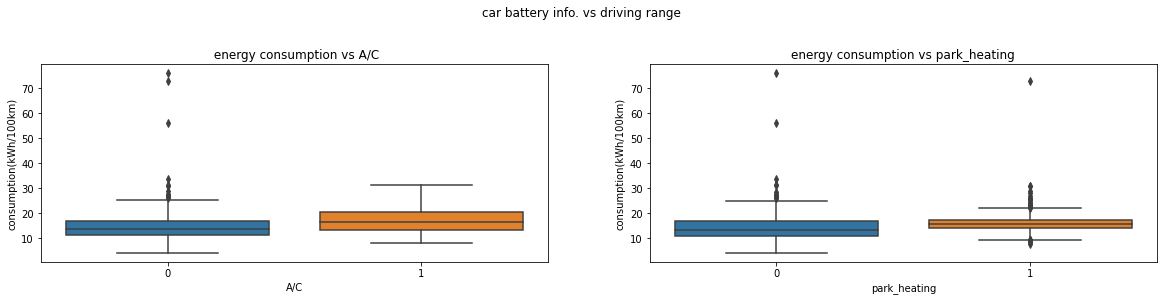

In [58]:
# a/c and park_heating in energy consumption
plt.figure(figsize=(20, 8))
plt.suptitle("car battery info. vs driving range")
plt.subplot(2, 2, 1)
plt.title(" energy consumption vs A/C")
sns.boxplot(x = 'A/C', y = 'consumption(kWh/100km)', data = df)

plt.subplot(2, 2, 2)
plt.title("energy consumption vs park_heating")
sns.boxplot(x = 'park_heating', y = 'consumption(kWh/100km)', data = df)
plt.show()

#### Observations

The energy consumption levels are higher with A/C on and park heating (range is within no park_heating)comparatively.

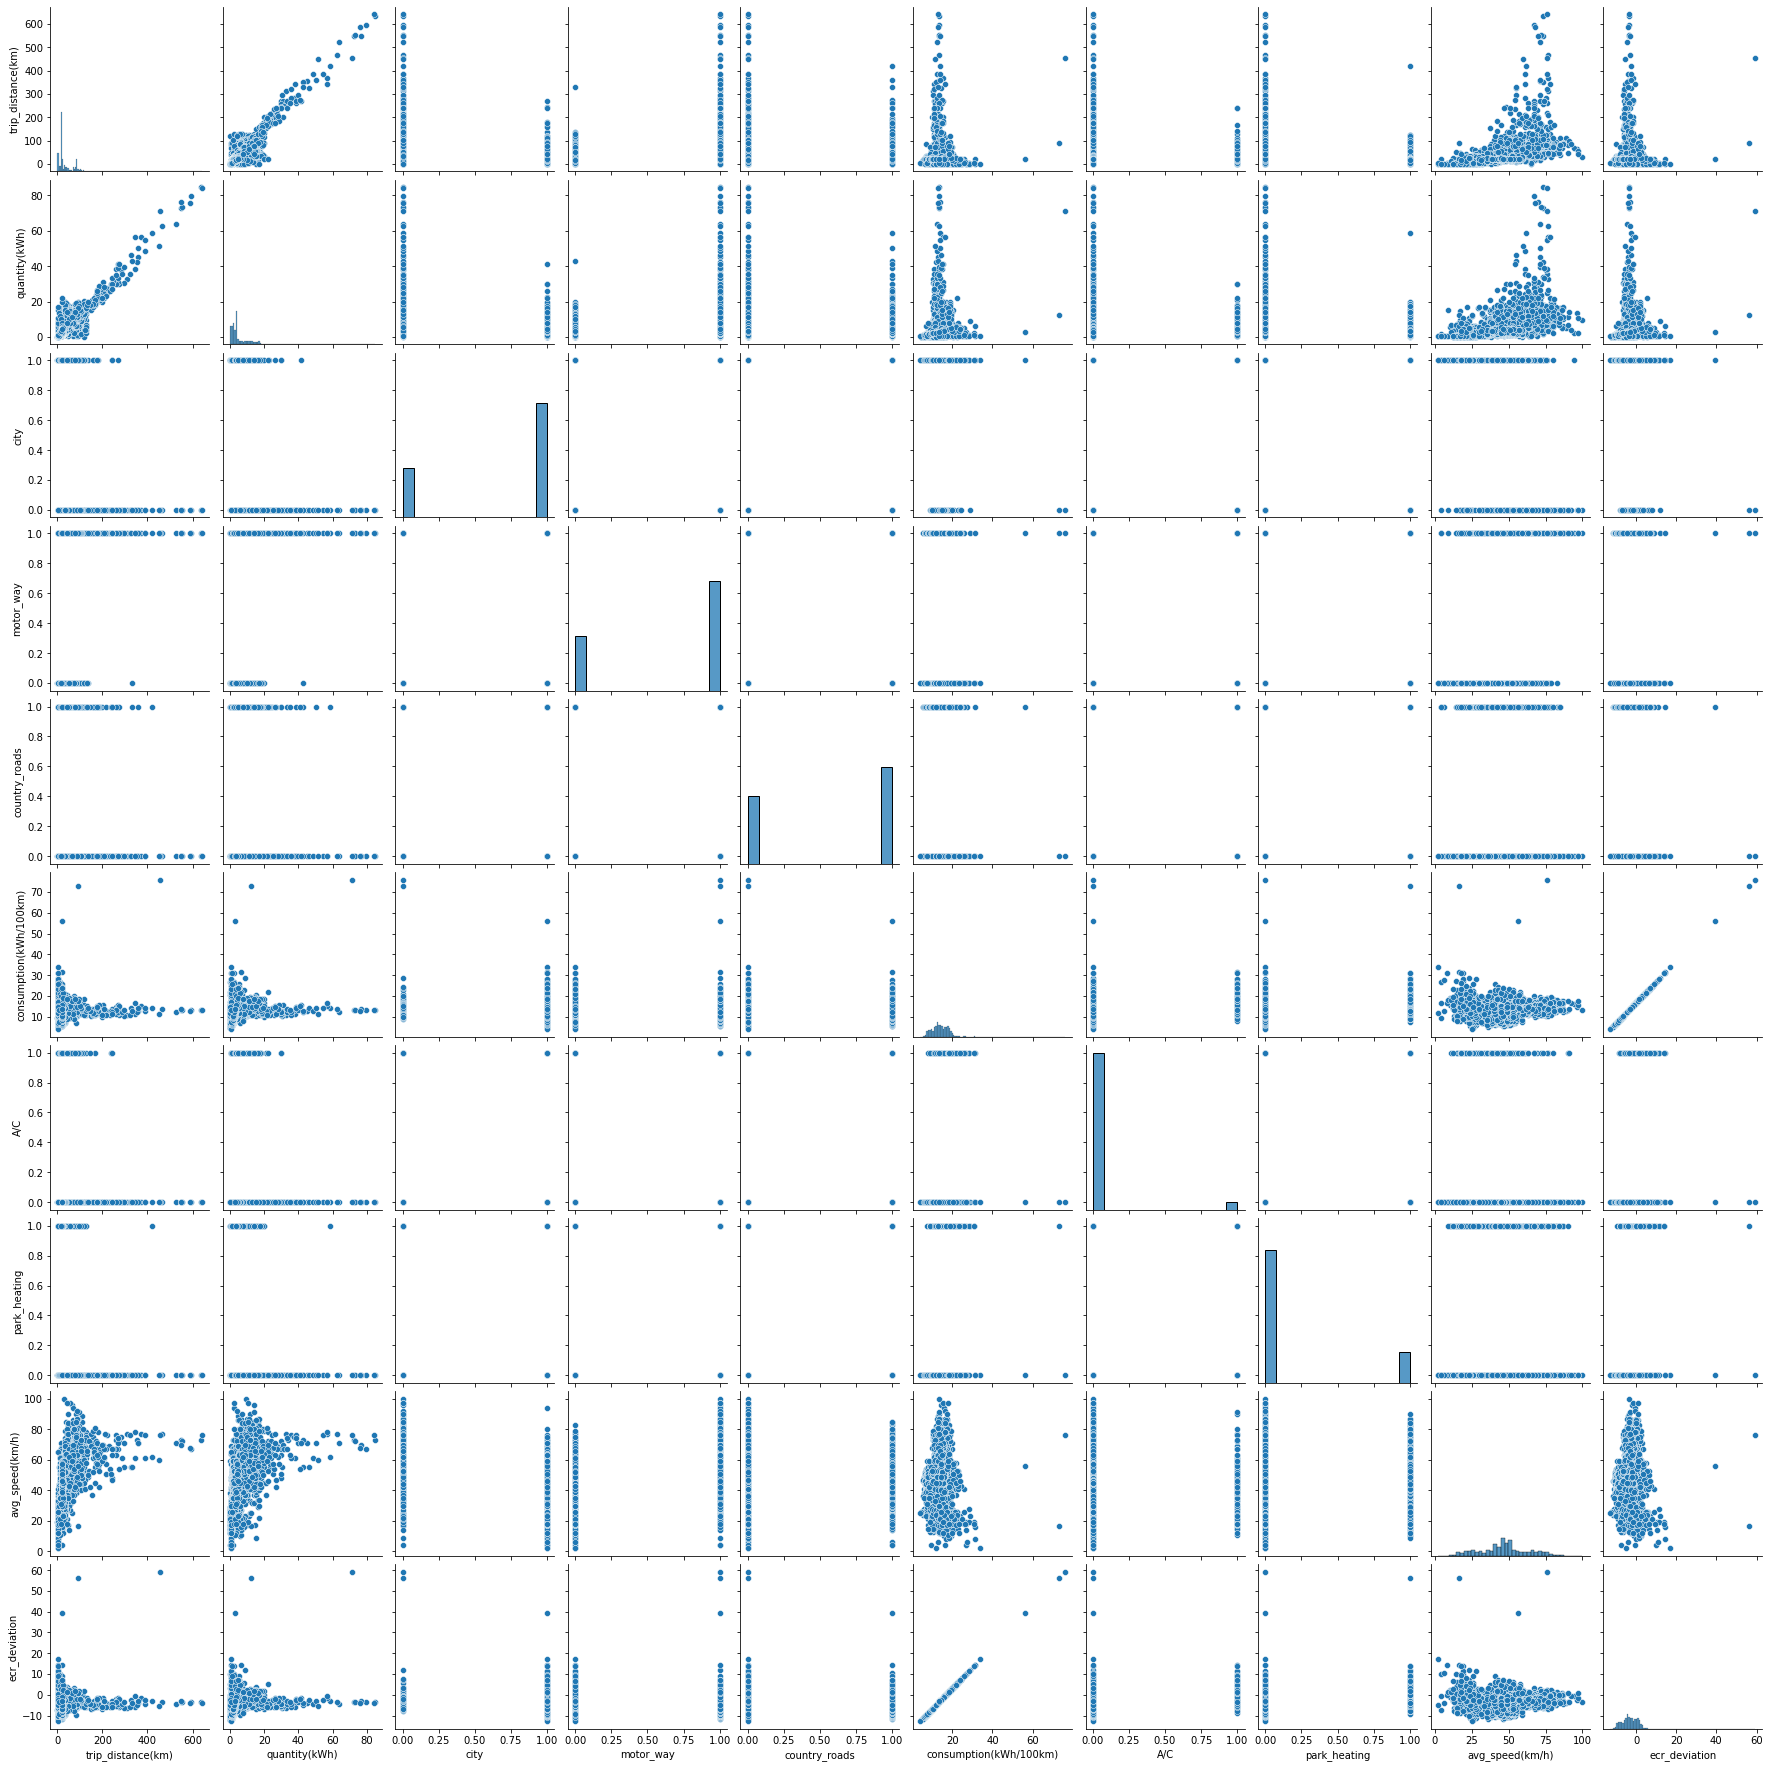

In [60]:
sns.pairplot(df)

In [61]:
df.corr()

,trip_distance(km),quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
trip_distance(km),1.000000,0.919314,-0.580042,0.241426,-0.212884,-0.023481,-0.025792,0.121538,0.549214,-0.023481
quantity(kWh),0.919314,1.000000,-0.600179,0.246189,-0.235485,0.104614,-0.010254,0.216558,0.530648,0.104614
city,-0.580042,-0.600179,1.000000,-0.261154,0.411102,-0.030727,0.052378,-0.402743,-0.638699,-0.030727
motor_way,0.241426,0.246189,-0.261154,1.000000,0.122945,0.099365,0.037404,0.077652,0.538162,0.099365
country_roads,-0.212884,-0.235485,0.411102,0.122945,1.000000,-0.038109,0.011543,-0.169260,-0.037784,-0.038109
consumption(kWh/100km),-0.023481,0.104614,-0.030727,0.099365,-0.038109,1.000000,0.164768,0.212497,-0.010582,1.000000
A/C,-0.025792,-0.010254,0.052378,0.037404,0.011543,0.164768,1.000000,-0.023256,-0.070122,0.164768
park_heating,0.121538,0.216558,-0.402743,0.077652,-0.169260,0.212497,-0.023256,1.000000,0.235456,0.212497
avg_speed(km/h),0.549214,0.530648,-0.638699,0.538162,-0.037784,-0.010582,-0.070122,0.235456,1.000000,-0.010582
ecr_deviation,-0.023481,0.104614,-0.030727,0.099365,-0.038109,1.000000,0.164768,0.212497,-0.010582,1.000000


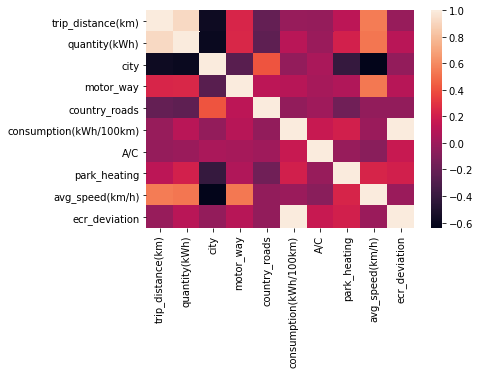

In [62]:
sns.heatmap(df.corr())
plt.show()

##### Observations

tire_type feature has no effect in predicting distance_range

'city', 'motor_way', 'driving_style', 'avg_speed(km/h)' impacts the trip distance.

A/C on has some effect on consumption and consumption have effect on driving range.

quantity above 20kwh is directly proportional to trip distance.

In [67]:
outliers_df = df[
    (df['quantity(kWh)'] > 40) |
    (df['consumption(kWh/100km)'] > 50) |
    (df['avg_speed(km/h)'] < 10) |
    (df['avg_speed(km/h)'] > 80)
]

In [68]:
outliers_df.shape

(78, 12)

In [69]:
outliers_df.head()

,trip_distance(km),quantity(kWh),tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
38,82.0,15.13,Winter tires,0,0,1,Normal,15.2,0,1,83.0,-1.6
78,74.0,14.51,Summer tires,0,1,0,Normal,15.2,0,1,85.0,-1.6
100,73.0,12.72,Summer tires,0,1,0,Normal,13.6,0,0,82.0,-3.2
102,72.0,13.22,Summer tires,0,1,0,Normal,12.9,0,0,83.0,-3.9
115,71.0,13.67,Summer tires,0,1,0,Normal,14.2,0,0,85.0,-2.6


In [72]:
non_outliers_df= df.drop(index=outliers_df.index)

In [73]:
non_outliers_df.to_csv('non_outliers_data.csv', index=False)

### Encode data and final processing

In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [76]:
# Encode the categorical variables tire_type and driving style
# Encode the driving style first with Ordinal Encoding. as Normal, Moderate, Fast as some order and significance.

ordinalEncoder = OrdinalEncoder(categories=[['Normal', 'Moderate', 'Fast']])
df['encoded_driving_style'] = ordinalEncoder.fit_transform(df.driving_style.values.reshape(-1,1))

display(df.tail(5))

,trip_distance(km),quantity(kWh),tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,encoded_driving_style
3340,26.0,5.62,Winter tires,1,1,1,Normal,21.6,1,0,45.0,4.8,0.0
3341,77.0,14.25,Winter tires,1,1,1,Normal,18.5,1,0,42.0,1.7,0.0
3342,26.0,4.97,Winter tires,1,1,1,Normal,19.1,1,0,23.0,2.3,0.0
3343,20.0,4.76,Winter tires,1,1,1,Fast,23.8,1,0,46.0,7.0,2.0
3344,43.0,7.86,Winter tires,1,1,1,Normal,18.3,1,0,18.0,1.5,0.0


In [77]:
labelEncoder = LabelEncoder()
df['encoded_tire_type'] = labelEncoder.fit_transform(df.tire_type)

display(df.head(5))

,trip_distance(km),quantity(kWh),tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,encoded_driving_style,encoded_tire_type
1,50.0,12.29,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3,0.0,1
2,43.0,8.68,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2,0.0,1
3,44.0,1.50,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7,0.0,1
4,76.0,14.44,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2,0.0,1
5,15.0,6.84,Winter tires,1,0,0,Normal,16.1,0,1,23.0,-0.7,0.0,1


In [78]:
# drop two columns
df.drop(columns = ['tire_type', 'driving_style'], inplace=True)
df.head(5)

,trip_distance(km),quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,encoded_driving_style,encoded_tire_type
1,50.0,12.29,0,0,1,15.5,0,1,47.0,-1.3,0.0,1
2,43.0,8.68,0,1,1,18.0,0,1,58.0,1.2,0.0,1
3,44.0,1.50,0,1,1,16.1,0,1,43.0,-0.7,0.0,1
4,76.0,14.44,0,1,0,19.0,0,1,76.0,2.2,0.0,1
5,15.0,6.84,1,0,0,16.1,0,1,23.0,-0.7,0.0,1


In [79]:
# save file
df.to_csv('final_preprocessed_with_outliers.csv', index=False)

In [80]:
ordinalEncoder = OrdinalEncoder(categories=[['Normal', 'Moderate', 'Fast']])
non_outlier_df['encoded_driving_style'] = ordinalEncoder.fit_transform(non_outlier_df.driving_style.values.reshape(-1,1))

labelEncoder = LabelEncoder()
non_outlier_df['encoded_tire_type'] = labelEncoder.fit_transform(non_outlier_df.tire_type)

In [81]:
non_outlier_df.drop(columns = ['tire_type', 'driving_style'], inplace=True)
non_outlier_df.head(5)

,trip_distance(km),quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,encoded_driving_style,encoded_tire_type
1,50.0,12.29,0,0,1,15.5,0,1,47.0,-1.3,0.0,1
2,43.0,8.68,0,1,1,18.0,0,1,58.0,1.2,0.0,1
3,44.0,1.50,0,1,1,16.1,0,1,43.0,-0.7,0.0,1
4,76.0,14.44,0,1,0,19.0,0,1,76.0,2.2,0.0,1
5,15.0,6.84,1,0,0,16.1,0,1,23.0,-0.7,0.0,1


In [82]:
# save file
non_outlier_df.to_csv('final_preprocessed_without_outliers.csv', index=False)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

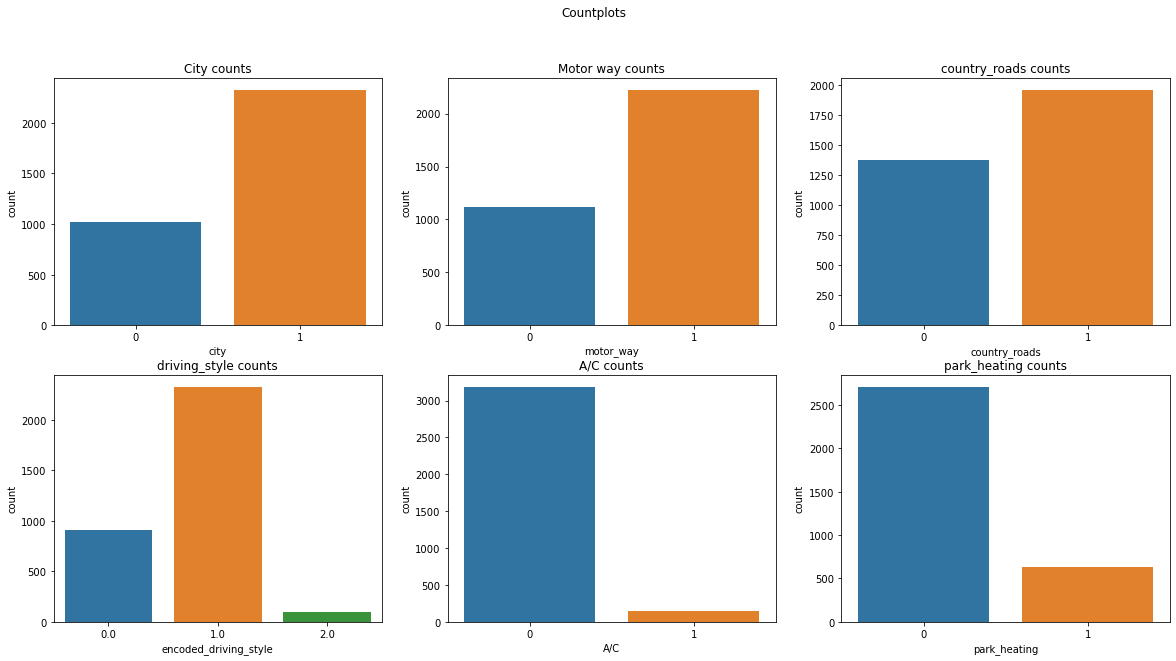

In [89]:
# analysis after encoding
plt.figure(figsize=(20, 10))
plt.suptitle("Countplots")
plt.subplot(2, 3, 1)
plt.title("City counts")
sns.countplot(df['city'])

plt.subplot(2, 3, 2)
plt.title("Motor way counts")
sns.countplot(df['motor_way'])

plt.subplot(2, 3, 3)
plt.title("country_roads counts")
sns.countplot(df['country_roads'])

plt.subplot(2, 3, 4)
plt.title("driving_style counts")
sns.countplot(df['encoded_driving_style'])

plt.subplot(2, 3, 5)
plt.title("A/C counts")
sns.countplot(df['A/C'])

plt.subplot(2, 3, 6)
plt.title("park_heating counts")
sns.countplot(df['park_heating'])

plt.show()